# Chapter 12: Discriminant Analysis and Other Linear Classification Models

In [1]:
from rpy2 import robjects
from rpy2.robjects.packages import importr, data
import os
import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder

plt.rcParams['axes.grid'] = True
plt.gray()

%matplotlib inline
pd.set_option('mode.chained_assignment',None)

<Figure size 640x480 with 0 Axes>

In [2]:
base = importr('base')
set_seed = robjects.r("set.seed")
APM = importr('AppliedPredictiveModeling')
APMdatafolder = os.path.expanduser("~/Documents/dataset/AppliedPredictiveModeling/data")
print(os.path.isdir(APMdatafolder))
unimelbdatafolder = os.path.expanduser("~/Documents/dataset/unimelb")
os.path.isdir(unimelbdatafolder)

True


True

In [3]:
traindata_filename='unimelb_training.csv'
trainfile_path = os.path.join(unimelbdatafolder, traindata_filename)

## 1. Data clean

### A few utility functions

In [4]:
def cleanRawData(raw0):
    raw = raw0.copy()
    raw['Sponsor.Code'] = raw['Sponsor.Code'].fillna('Unk')
    raw['Sponsor.Code'] = 'Sponsor'+raw['Sponsor.Code']

    raw['Grant.Category.Code'] = raw['Grant.Category.Code'].fillna('Unk')
    raw['Grant.Category.Code'] = 'GrantCat'+raw['Grant.Category.Code']

    raw['Contract.Value.Band...see.note.A'] = raw['Contract.Value.Band...see.note.A'].fillna('Unk')
    raw['Contract.Value.Band...see.note.A'] = 'ContractValueBand'+raw['Contract.Value.Band...see.note.A']

    raw['Role.1'] = raw['Role.1'].fillna('Unk')
    return raw
    
def getVerticalData(raw):
    namesPre = []
    int1to15 = [str(x) for x in range(1,16)]
    for x in raw.columns:
        if x[x.rfind(".")+1:] in int1to15:
            if x[:x.rfind(".")] not in namesPre:
                namesPre.append(x[:x.rfind(".")])
                
    tmp = []
    for i in range(1,16):
        tmpData = pd.DataFrame()
        tmpData['Grant.Application.ID'] = raw['Grant.Application.ID']
        for x in namesPre:
            if x+'.'+str(i) in raw.columns:
                tmpData[x] = raw[x+'.'+str(i)]
        tmp.append(tmpData)
    vertical = pd.concat(tmp)
    vertical = vertical[vertical['Role'].notnull()]
    return vertical

def cleanVerticalData(v0):
    v = v0.copy()
    v.loc[v['Country.of.Birth'].notnull(),'Country.of.Birth'] = \
        v[v['Country.of.Birth'].notnull()]['Country.of.Birth'].apply(lambda x: x.replace(" ",""))
    
    v['Home.Language'] = v['Home.Language'].apply(lambda x: 'OtherLang' if x=='Other' else x)
    v['Dept.No.'] = v['Dept.No.'].apply(lambda x: 'Dept'+str(int(x)) if pd.notna(x) else 'DeptNA')
    v['Faculty.No.'] = v['Faculty.No.'].apply(lambda x: 'Faculty'+str(int(x)) if pd.notna(x) else 'FacultyNA')
    
    v['RFCD.Code'] = v['RFCD.Code'].apply(lambda x: 'RFCD'+str(int(x)) if pd.notna(x) else 'RFCDNA')
    v['RFCD.Code'] = v['RFCD.Code'].apply(lambda x: 'RFCDNA' if x in ['RFCD0','RFCD999999'] else x)
    v.loc[v['RFCD.Code'].isin(['RFCDNA']),'RFCD.Percentage'] = None
    
    v['SEO.Code'] = v['SEO.Code'].apply(lambda x: 'SEO'+str(int(x)) if pd.notna(x) else 'SEONA')
    v['SEO.Code'] = v['SEO.Code'].apply(lambda x: 'SEONA' if x in ['SEO0','SEO999999'] else x)
    v.loc[v['SEO.Code'].isin(['SEONA']),'SEO.Percentage'] = None
    
    colName = 'No..of.Years.in.Uni.at.Time.of.Grant'
    v[colName] = v[colName].map({'>=0 to 5':'Duration0to5',
                                 '>5 to 10':'Duration5to10',
                                 '>10 to 15':'Duration10to15',
                                 'more than 15':'DurationGT15',
                                 'Less than 0':'DurationLT0'},
                           na_action='ignore')
    v[colName] = v[colName].fillna('DurationUnk')
    
    return v

def noZV(w): 
    dropColumns = []
    for c in w.columns:
        if len(w[c].drop_duplicates())==1:
            dropColumns.append(c)
    return w.drop(columns = dropColumns)
    
def getSummaryData(v):
    people, totalPub, investPub, investDuration, investFaculty, investDept, investGrants, \
        investPhD, investLang, investCountry, investDOB, investCount, grantData, SEOcount, RFCDcount \
        = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),\
        pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(),\
        pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    allID = v[['Grant.Application.ID']].drop_duplicates().sort_values('Grant.Application.ID')
    
    shortNames = {"EXT_CHIEF_INVESTIGATOR":"ECI", "STUD_CHIEF_INVESTIGATOR":"SCI", "CHIEF_INVESTIGATOR":"CI",\
                 "DELEGATED_RESEARCHER":"DR", "EXTERNAL_ADVISOR":"EA", "HONVISIT":"HV",\
                 "PRINCIPAL_SUPERVISOR":"PS", "STUDRES":"SR", "Unk":"UNK", "":""}
    
    # calculate the number of people per Grant application
    w = v.groupby('Grant.Application.ID').agg(numPeople = ('Grant.Application.ID','count')).reset_index()
    people = noZV(allID.merge(w, on = ['Grant.Application.ID'], how = 'left'))
    
    # calculate the number of people per role
    pt = v[['Grant.Application.ID','Role']].groupby(['Grant.Application.ID', 'Role']).\
        agg(num = ('Role','count')).reset_index().\
        pivot(index = 'Grant.Application.ID',columns = 'Role').reset_index()
    newcolname = [x[0]+shortNames[x[1]] for x in pt.columns]
    pt.columns = newcolname
    pt = pt.fillna(0)
    investCount = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # for each role, calculate the frequency of people in each age group
    x = v[['Grant.Application.ID','Role','Year.of.Birth']].\
        groupby(['Grant.Application.ID','Role','Year.of.Birth']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Year.of.Birth','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Year.of.Birth'].astype(int).astype(str)
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    investDOB = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # for each role, calculate the frequency of people from each country
    x = v[['Grant.Application.ID','Role','Country.of.Birth']].\
        groupby(['Grant.Application.ID','Role','Country.of.Birth']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Country.of.Birth','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Country.of.Birth']
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    investCountry = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # for each role, calculate the frenquency of people for each language
    x = v[['Grant.Application.ID','Role','Home.Language']].\
        groupby(['Grant.Application.ID','Role','Home.Language']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Home.Language','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Home.Language']
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    investLang = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left').fillna(0))
    
    # for each role, determine who has a Ph.D
    x = v[['Grant.Application.ID','Role','With.PHD']].\
        groupby(['Grant.Application.ID','Role','With.PHD']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['With.PHD','Role'])    
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+'.PhD'
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    for x in ['EA.PhD','SCI.PhD','UNK.PhD']:
        pt[x]=0
    investPhD = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # for each role, calculate the number of successful and unsuccessful grants
    x = v[['Grant.Application.ID','Role','Number.of.Successful.Grant']].\
        groupby(['Grant.Application.ID','Role']).\
        agg(num = ('Number.of.Successful.Grant','sum')).reset_index()
    x = x.sort_values(['Role'])
    x['roleC'] = 'Success.'+x['Role'].map(shortNames,na_action = 'ignore')
    
    y = v[['Grant.Application.ID','Role','Number.of.Unsuccessful.Grant']].\
        groupby(['Grant.Application.ID','Role']).\
        agg(num = ('Number.of.Unsuccessful.Grant','sum')).reset_index()
    y = y.sort_values(['Role'])
    y['roleC'] = 'Unsuccess.'+y['Role'].map(shortNames,na_action = 'ignore')
    pt = pd.concat([x,y]).pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    investGrants = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create variables for each role/department combination
    x = v[['Grant.Application.ID','Role','Dept.No.']].\
        groupby(['Grant.Application.ID','Role','Dept.No.']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Dept.No.','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Dept.No.']
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]
    pt = pt[[x for x in pt.columns if 'DeptNA' not in x]]
    investDept = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create variables for each role/faculty
    x = v[['Grant.Application.ID','Role','Faculty.No.']].\
        groupby(['Grant.Application.ID','Role','Faculty.No.']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    x = x.sort_values(['Faculty.No.','Role'])
    x['roleC'] = x['Role'].map(shortNames,na_action = 'ignore')+"."+x['Faculty.No.']
    pt = x.pivot(index = 'Grant.Application.ID',columns = 'roleC',values = 'num').fillna(0).reset_index()
    pt.columns.names = [None]    
    pt = pt[[x for x in pt.columns if 'NA' not in x]]
    investFaculty = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create dummy variables for each tenure length
    x = v[['Grant.Application.ID','No..of.Years.in.Uni.at.Time.of.Grant']].\
        groupby(['Grant.Application.ID','No..of.Years.in.Uni.at.Time.of.Grant']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    pt = x.pivot(index = 'Grant.Application.ID', columns = 'No..of.Years.in.Uni.at.Time.of.Grant', values = 'num').fillna(0)
    pt.columns.names = [None]
    investDuration = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create variables for the number of publications per journal type. 
    # Note that we also compute the total number, 
    # which should be removed for models that cannot deal with such a linear dependency
    x = v[['Grant.Application.ID','A.','A','B','C']].\
    groupby('Grant.Application.ID').\
    agg(AstarTotal = ('A.','sum'), ATotal=('A','sum'),BTotal = ('B', 'sum'), CTotal = ('C','sum')).reset_index().fillna(0)
    x['allPub'] = x['AstarTotal']+x['ATotal']+x['BTotal']+x['CTotal']
    totalPub = x
    
    # Create variables for the number of publications per journal type per role.
    x = v[['Grant.Application.ID','Role','A.','A','B','C']].rename(columns={'A.':'Astar'}).\
        groupby(['Grant.Application.ID','Role']).\
        agg({'Astar':'sum','A':'sum', 'B':'sum','C':'sum'}).reset_index()
    pt = x.pivot(index='Grant.Application.ID', columns = 'Role', values = ['Astar','A','B','C']).fillna(0)
    newColNames = [x[0]+'.'+shortNames[x[1]] for x in pt.columns]
    pt.columns = newColNames
    pt = pt.reset_index()
    investPub = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))
    
    # Create variables for each RFCD code
    x = v[['Grant.Application.ID','RFCD.Code']].\
        groupby(['Grant.Application.ID','RFCD.Code']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    pt = x.pivot(index='Grant.Application.ID', columns = 'RFCD.Code',values = 'num').reset_index().drop(columns = ['RFCDNA']).fillna(0)
    pt.columns.names=[None]
    RFCDcount = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))

    # Create variables for each SEO code
    x = v[['Grant.Application.ID','SEO.Code']].\
        groupby(['Grant.Application.ID','SEO.Code']).\
        agg(num = ('Grant.Application.ID','count')).reset_index()
    pt = x.pivot(index='Grant.Application.ID', columns = 'SEO.Code',values = 'num').reset_index().fillna(0).drop(columns = ['SEONA'])
    pt.columns.names=[None]
    SEOcount = noZV(allID.merge(pt, on = ['Grant.Application.ID'], how = 'left'))    
    
    # Create the grantData
    x = raw[["Sponsor.Code", "Contract.Value.Band...see.note.A", "Grant.Category.Code"]]
    enc = OneHotEncoder(handle_unknown='ignore')

    startTime = raw['Start.date'].apply(lambda x : datetime.strptime(x,'%d/%m/%y'))
    startYear = startTime.apply(lambda x: x.year)

    mthabbre=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    wdayabbre = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    x['Month'] = startTime.apply(lambda x: mthabbre[x.month-1])
    x['Day'] = startTime.apply(lambda x: x.day)
    x['yDay'] = startTime.apply(lambda x: 1+(x- datetime.strptime('1/1/'+str(x.year),'%d/%m/%Y')).days)
    x['Weekday']=startTime.apply(lambda x: wdayabbre[x.dayofweek])

    y = enc.fit_transform(np.array(x[['Sponsor.Code', "Contract.Value.Band...see.note.A", "Grant.Category.Code",'Month','Weekday']]))
    y = pd.DataFrame(data = y.toarray(),columns = enc.get_feature_names_out())
    y = y.rename(columns = dict(zip(list(y.columns), [x[3:] for x in y.columns])))
    y['Day'] = x['Day']
    y['yDay'] = x['yDay']
    y['Grant.Application.ID'] = raw['Grant.Application.ID']
    y['Class'] = raw['Grant.Status'].map({0:'unsuccessful', 1:'successful'})
    y['is2008'] = startYear == 2008
    y.columns = [a.strip() for a in y.columns]
    grantData = noZV(y)
    
    # Merge all the predictors together, remove zero variance columns and merge in the outcome data
    summarized = investCount
    for x in [investDOB, investCountry, investLang, investPhD, investGrants, \
        investDept, investFaculty, investDuration, investPub, totalPub, people, RFCDcount, SEOcount, grantData]:
        summarized = summarized.merge(x, on = ['Grant.Application.ID'], how = 'left')
    
    return investCount, investDOB, investCountry, investLang, investPhD, investGrants, \
        investDept, investFaculty, investDuration, investPub, totalPub, people, RFCDcount, SEOcount, grantData, summarized

In [5]:
def checkVerticalData(v):
    vertical_filename='vertical.csv'
    vertical_path = os.path.join(unimelbdatafolder, vertical_filename)

    v0 = pd.read_csv(vertical_path)
    v0['RFCD.Code'] = v0['RFCD.Code'].fillna('RFCDNA')
    v0['SEO.Code'] = v0['SEO.Code'].fillna('SEONA')
    v0['Dept.No.'] = v0['Dept.No.'].fillna('DeptNA')
    v0['Faculty.No.'] = v0['Faculty.No.'].fillna('FacultyNA')

    v0s = v0.sort_values(['Grant.Application.ID','RFCD.Code']).reset_index(drop=True)
    vs = v.sort_values(['Grant.Application.ID','RFCD.Code']).reset_index(drop=True)
    return v0s.equals(vs)

def checkSummaryData(summary):
    s = summary[-1].copy()
    s.columns = [x.lower() for x in s.columns]
    s =s.drop(columns = ['grant.application.id'])
    if 'yday' in s.columns:
        s = s.drop(columns=['yday'])

    summary_filename='summarized.csv'
    summary_path = os.path.join(unimelbdatafolder, summary_filename)
    s0 = pd.read_csv(summary_path)
    s0.columns = [x.lower() for x in s0.columns]

    cm = s[list(s0.columns)]==(s0)
    diffcol = []
    for x in s.columns:
        if (len(cm[x].value_counts())!=1):
            diffcol.append(x)

    # Check columns with PhD information: differ by NaN values
    p = summary[4].copy()
    p.columns = [x.lower() for x in p.columns]

    PHD_filename='investPhD.csv'
    PHD_path = os.path.join(unimelbdatafolder, PHD_filename)

    p0 = pd.read_csv(PHD_path)
    p0.columns = [x.lower() for x in p0.columns]
    p0 = p0[list(p.columns)]

    p = p.fillna('Missing')
    p0 = p0.fillna('Missing')

    # Check country columns: fill nan by 0 in getSummaryData
    c = summary[2].copy()
    c.columns = [x.lower() for x in c.columns]
    for x in c.columns:
        c[x]=c[x].fillna(0).astype('int64')

    Country_filename='investCountry.csv'
    Country_path = os.path.join(unimelbdatafolder, Country_filename)

    c0 = pd.read_csv(Country_path)
    c0.columns = [x.lower() for x in c0.columns]
    c0 = c0[list(c.columns)]

    # Check DOB columns: fill nan by 0 in getSummaryData
    b = summary[1].copy()
    b.columns = [x.lower() for x in b.columns]
    for x in b.columns:
        b[x]=b[x].fillna(0).astype('int64')

    DOB_filename='investDOB.csv'
    DOB_path = os.path.join(unimelbdatafolder, DOB_filename)

    b0 = pd.read_csv(DOB_path)
    b0.columns = [x.lower() for x in b0.columns]
    b0 = b0[list(b.columns)]

    return "Columns in Country and Date.of.Birth needs to fill null values by 0", {'PhD':p0.equals(p), 'Country': c0.equals(c), 'Date.of.Birth':b0.equals(b)}, \
    [x for x in list(c.columns)+list(b.columns) if x.lower()!='grant.application.id']

In [6]:
def getTrainTestData(s):
    summarized = s.copy()
    col1 = [x for x in summarized.columns if x.lower() =='is2008'][0]
    col2 = [x for x in summarized.columns if x.lower() =='grant.application.id'][0]
    
    training = summarized[~summarized[col1]] # data not in 2008
    year2008= summarized[summarized[col1]] # data in 2008

    np.random.seed(552)
    inTrain = np.random.choice(year2008.index, size = 1557, replace = False) # add 1557 records into training

    training2 = year2008[year2008.index.isin(inTrain)]
    testing = year2008[~year2008.index.isin(inTrain)] # 518 records of year 2008 as testing
    training = pd.concat([training, training2])

    training = training.drop(columns = [col1,col2])
    testing = testing.drop(columns = [col1,col2])

    training = noZV(training)
    testing = testing[list(training.columns)]
    year2008 = year2008[list(training.columns)]
    return training, testing, year2008

In [7]:
def removeHighCorrColumns(XTrain, threshold = 0.99):
    corr_df = XTrain.corr().fillna(0)
    for i in range(len(corr_df)):
        corr_df.iloc[i,i] = 0
    abs_corr = np.abs(np.array(corr_df))
    columnnames = list(corr_df.columns)

    while abs_corr.max() > threshold:
        i, j = np.unravel_index(abs_corr.argmax(), abs_corr.shape)
        #print(i,j, abs_corr.max())
        if abs_corr[i,].mean()> abs_corr[j,].mean():
            k = i
        else:
            k = j
        columnnames.pop(k)
        abs_corr = np.delete(abs_corr, k, axis = 0)
        abs_corr = np.delete(abs_corr, k, axis = 1)
    return columnnames

def nearZeroVar(X, freqCut):
    columnnames = list(X.columns)
    percentUnique, freqRatio, zeroVar, nzv = [], [], [], []
    for c in columnnames:
        w = X[c]
        valcnt = w.value_counts().values
        percentUnique.append(100* len(valcnt)/valcnt.sum())
        zeroVar.append(True if len(valcnt)==1 else False)
        if len(valcnt)==1: 
            freqRatio.append(0)
        else:
            freqRatio.append(valcnt[0]/valcnt[1])
        nzv.append(freqRatio[-1]==0 or freqRatio[-1]>freqCut)
    df = pd.DataFrame({'col':columnnames, 'freqRatio':freqRatio, 'zeroVar':zeroVar,'nzv':nzv}).set_index('col')
    df.index.name = None
    return df

def getFullSetReducedSet(training):
    fullSet = [x for x in training.columns if x.lower()!='class']
    XTrain = training[fullSet]
    col1 = removeHighCorrColumns(XTrain)
    fullSet = col1

    isNZV = nearZeroVar(training[fullSet], int(len(training)/5))
    fullSet = list(isNZV[~isNZV['nzv']].index)

    reducedSet = list(isNZV[(~isNZV['nzv']) & (isNZV['freqRatio']<int(len(training)/50))].index)
    reducedSet = [x for x in reducedSet if x.lower() not in ['allpub','numpeople','mar','sun']]
    return fullSet, reducedSet

### Read csv file and get summary data

In [252]:
raw = pd.read_csv(trainfile_path, low_memory=False)
raw = raw.drop(columns = ['Unnamed: 251'])
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Columns: 251 entries, Grant.Application.ID to C.15
dtypes: float64(179), int64(2), object(70)
memory usage: 16.7+ MB


In [269]:
raw = cleanRawData(raw)
vertical = cleanVerticalData((getVerticalData(raw)))

s = getSummaryData(vertical)
#m, dic, l = checkSummaryData(s)
# pd.DataFrame(l).to_csv('./fillNAlist.csv',index=False)
l = pd.read_csv('./fillNAlist.csv')['0'].to_list()

summarized = s[-1]
fillList = [x for x in summarized.columns if x.lower() in l]
summarized[fillList] = summarized[fillList].fillna(0)

In [ ]:
summarized.info()

In [12]:
# year 2008 has 2075 records, pre 2008 has 6633 records
# Training : pre2008 data + 1557 records in year 2008
# Testing: 518 records in year 2008
training, testing, year2008Data = getTrainTestData(summarized)

In [13]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8707
Columns: 1894 entries, numCI to Class
dtypes: float64(1890), int64(3), object(1)
memory usage: 118.4+ MB


In [187]:
'''
fullSet, reducedSet = getFullSetReducedSet(training)
pd.DataFrame({'colName':fullSet}).to_csv("./fullset.csv",index=False)
pd.DataFrame({'colName':reducedSet}).to_csv("./reducedset.csv",index=False)
'''

In [16]:
pre2008Data = training[~training.index.isin(year2008Data.index)]
test2008 = testing

allData=training
holdout2008 = testing

In [17]:
np.array(pre2008Data).shape, np.array(test2008).shape, np.array(allData).shape, np.array(holdout2008).shape

((6633, 1894), (518, 1894), (8190, 1894), (518, 1894))

In [87]:
fullSet = pd.read_csv("./fullset.csv")['colName'].to_list()
reducedSet = pd.read_csv("./reducedset.csv")['colName'].to_list()

In [89]:
len(fullSet), len(reducedSet) #1070,  256 after adding yDay

(1069, 255)

In [70]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, ShuffleSplit

In [21]:
def modelPerf(model, X, y):
    y_true = y
    y_pred = model.predict(X)
    print(f"Report of {model.__class__.__name__}:")
    print(classification_report(y_true, y_pred, digits = 7))
    
    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred), display_labels=model.classes_)
    cmdisp.plot(ax = ax1)
    
    y_score = model.predict_proba(X)[:,1]
    roc_area = roc_auc_score(y_true, y_score)
    ax2 = f.add_subplot(122)
    roc_disp = RocCurveDisplay.from_estimator(model, X, y, ax = ax2)
    print(f"The area under the ROC curve is {roc_area}")

In [109]:
cv = ShuffleSplit(n_splits = 4, test_size = 0.25, random_state=3)

logReg_param = [{'solver': ['lbfgs','newton-cg','newton-cholesky','sag'],
                 'penalty':['l2',None]},
                {'solver': ['libliner'],
                 'penalty':['l1','l2']},
                {'solver': ['saga'],
                 'penalty':['l1','l2',None]}]

## 2. Logistic Regression
{0:'unsuccessful', 1:'successful'}

In [110]:
trainData = pre2008Data
validData = training[training.index.isin(year2008Data.index)]
fillNAcols = ['CI.PhD','DR.PhD','ECI.PhD','HV.PhD','PS.PhD','SR.PhD','EA.PhD','SCI.PhD','UNK.PhD']
trainData[fillNAcols] = trainData[fillNAcols].fillna(0)
validData[fillNAcols] = validData[fillNAcols].fillna(0)

trainData['yDay2'] = trainData['yDay']**2
validData['yDay2'] = validData['yDay']**2

In [111]:
trainX0 = trainData.drop(columns = ['Class'])
trainy = trainData['Class'].apply(lambda x : 1 if x =='successful' else 0)
validX0 = validData.drop(columns = ['Class'])
validy = validData['Class'].apply(lambda x : 1 if x =='successful' else 0)

### 2.1 One feature

In [116]:
onefeatName = ['yDay']
trainX = trainX0[onefeatName]
validX = validX0[onefeatName]

In [118]:
modelFit= linear_model.LogisticRegression()
modelFit.fit(trainX, trainy)

LogisticRegression()

In [119]:
lin_a = modelFit.coef_[0][0]
lin_b = modelFit.intercept_[0]

lin_a, lin_b

(-0.004238095577989463, 0.9193353121819308)

In [122]:
quad = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
trainX_quad= quad.fit_transform(trainX)

lr = linear_model.LogisticRegression()
daySquareGS= GridSearchCV(lr, logReg_param, cv = cv, scoring = "roc_auc", n_jobs = -1)
daySquareGS.fit(trainX_quad, trainy)
daySquareModel = daySquareGS.best_estimator_

/Users/chenxu/miniconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/chenxu/miniconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/chenxu/miniconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/chenxu/miniconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/chenxu/miniconda3/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: 

Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.5891643 0.7900000 0.6749592      3400
           1  0.6557377 0.4206619 0.5125306      3233

    accuracy                      0.6099804      6633
   macro avg  0.6224510 0.6053310 0.5937449      6633
weighted avg  0.6216129 0.6099804 0.5957896      6633

The area under the ROC curve is 0.588622477756955


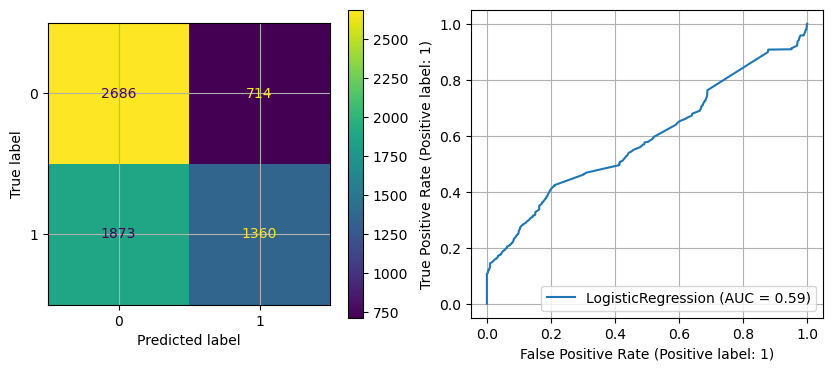

In [124]:
modelPerf(modelFit,trainX, trainy)

Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.5712399 0.8902941 0.6959421      3400
           1  0.7203898 0.2972471 0.4208452      3233

    accuracy                      0.6012362      6633
   macro avg  0.6458148 0.5937706 0.5583936      6633
weighted avg  0.6439372 0.6012362 0.5618567      6633

The area under the ROC curve is 0.6192974108913593


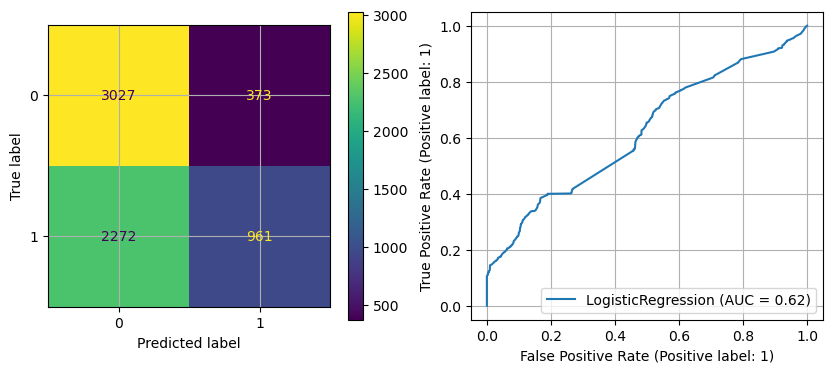

In [125]:
modelPerf(daySquareModel,trainX_quad,trainy)

In [131]:
df1=pd.DataFrame({'yDay':trainX['yDay'],'output':trainy})
df1['dayBin'] = pd.cut(df1.yDay, list(range(1,366,5)),right=False)
df2 = df1.groupby('dayBin').agg({'output':'mean'}).reset_index()
df2['leftPt'] = df2['dayBin'].apply(lambda x: x.left)

sqc1, sqc2 = daySquareModel.coef_[0]
sq_b = daySquareModel.intercept_[0]

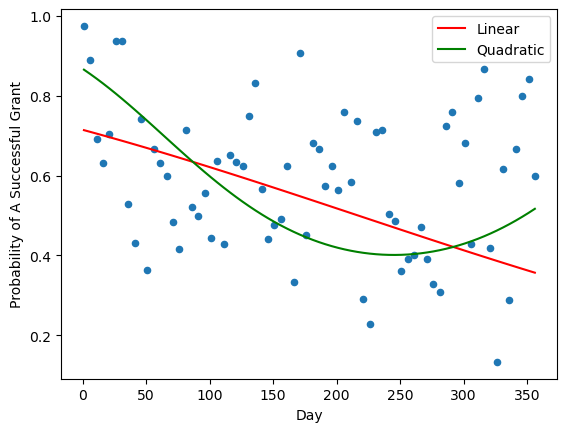

In [132]:
dx = np.linspace(1,356,72)
dy = 1/(1+np.exp(-(lin_b+lin_a*dx)))
dz = 1/(1+np.exp(-(sq_b +sqc1*dx +sqc2*dx*dx)))

ax1 = df2.plot.scatter(x = 'leftPt', y = 'output',grid = False, xlabel = 'Day', ylabel = 'Probability of A Successful Grant')
ax1.plot(dx,dy, c='red', label = 'Linear')
ax1.plot(dx,dz, c='green', label = 'Quadratic')
_ = ax1.legend()

### 2.2 Reduced set and full set

In [133]:
trainX = trainX0[reducedSet+['yDay2']]
validX = validX0[reducedSet+['yDay2']]

In [137]:
lrReducedGS = GridSearchCV(lr, logReg_param, cv=cv, scoring = 'roc_auc', n_jobs = -1)
lrReducedGS.fit(trainX, trainy)

/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

GridSearchCV(cv=ShuffleSplit(n_splits=4, random_state=3, test_size=0.25, train_size=None),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'penalty': ['l2', None],
                          'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                     'sag']},
                         {'penalty': ['l1', 'l2'], 'solver': ['libliner']},
                         {'penalty': ['l1', 'l2', None], 'solver': ['saga']}],
             scoring='roc_auc')

In [138]:
lr_reduced = lrReducedGS.best_estimator_

Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.8447205 0.8400000 0.8423536      3400
           1  0.8327183 0.8376121 0.8351581      3233

    accuracy                      0.8388361      6633
   macro avg  0.8387194 0.8388061 0.8387558      6633
weighted avg  0.8388705 0.8388361 0.8388464      6633

The area under the ROC curve is 0.9160706682920617


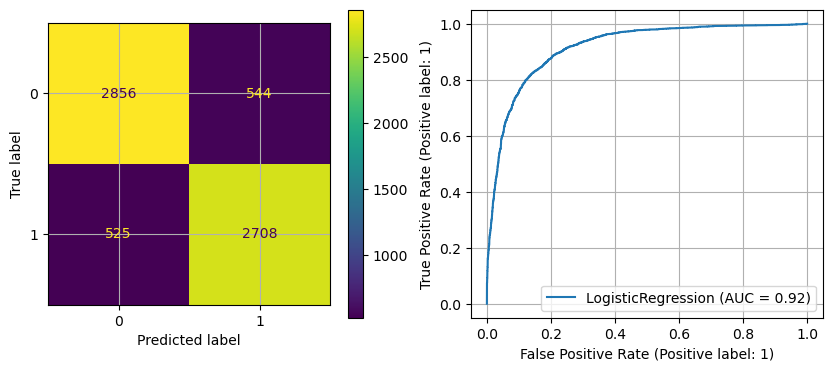

In [139]:
modelPerf(lr_reduced, trainX, trainy)

Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.8729989 0.8262626 0.8489881       990
           1  0.7225806 0.7901235 0.7548441       567

    accuracy                      0.8131021      1557
   macro avg  0.7977898 0.8081930 0.8019161      1557
weighted avg  0.8182223 0.8131021 0.8147044      1557

The area under the ROC curve is 0.876586856216486


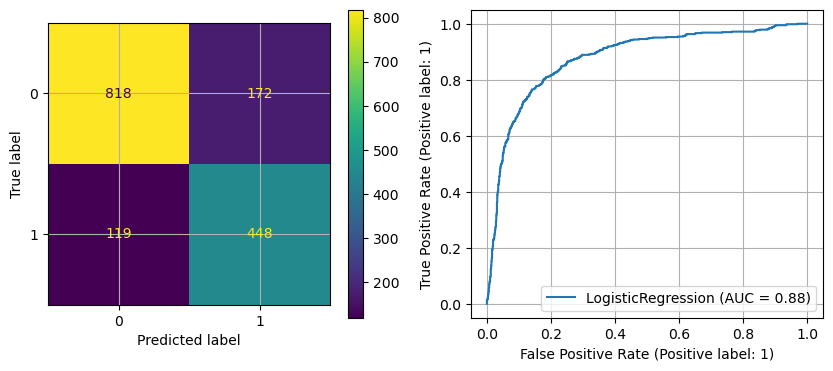

In [140]:
modelPerf(lr_reduced, validX, validy)

In [141]:
trainX = trainX0[fullSet+['yDay2']]
validX = validX0[fullSet+['yDay2']]

In [142]:
lrFullGS = GridSearchCV(lr, logReg_param, cv=cv, scoring = 'roc_auc', n_jobs = -1)
lrFullGS.fit(trainX, trainy)
lr_full = lrFullGS.best_estimator_

/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chenxu/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.8733470 0.8741176 0.8737322      3400
           1  0.8674923 0.8666873 0.8670896      3233

    accuracy                      0.8704960      6633
   macro avg  0.8704197 0.8704025 0.8704109      6633
weighted avg  0.8704934 0.8704960 0.8704945      6633

The area under the ROC curve is 0.9404639653572533


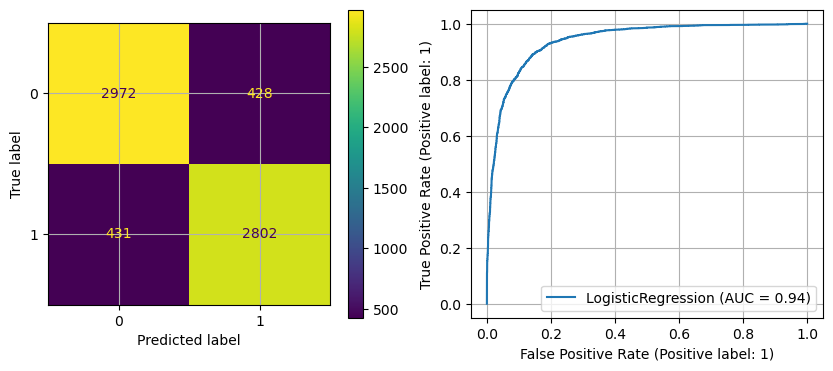

In [143]:
modelPerf(lr_full, trainX, trainy)

Report of LogisticRegression:
              precision    recall  f1-score   support

           0  0.8774194 0.8242424 0.8500000       990
           1  0.7224880 0.7989418 0.7587940       567

    accuracy                      0.8150289      1557
   macro avg  0.7999537 0.8115921 0.8043970      1557
weighted avg  0.8209993 0.8150289 0.8167862      1557

The area under the ROC curve is 0.8723219852849483


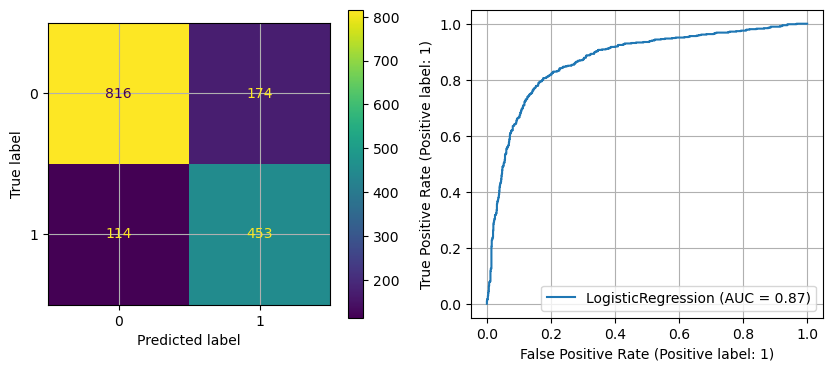

In [144]:
modelPerf(lr_full, validX, validy)

## 3. Linear Discriminant Analysis

In [146]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [157]:
trainX = trainX0[reducedSet+['yDay2']]
validX = validX0[reducedSet+['yDay2']]

In [158]:
sc = StandardScaler()
trainX_scaled = sc.fit_transform(trainX)
validX_scaled = sc.fit_transform(validX)

In [159]:
lda = LinearDiscriminantAnalysis()
lda_param = {'solver': ['svd','lsqr','eigen']}

In [160]:
ldaGS = GridSearchCV(lda, lda_param, cv = cv, scoring = 'roc_auc', n_jobs = -1)
ldaGS.fit(trainX_scaled, trainy)
ldaModel = ldaGS.best_estimator_

Report of LinearDiscriminantAnalysis:
              precision    recall  f1-score   support

           0  0.9025522 0.7858586 0.8401728       990
           1  0.6949640 0.8518519 0.7654517       567

    accuracy                      0.8098908      1557
   macro avg  0.7987581 0.8188552 0.8028122      1557
weighted avg  0.8269565 0.8098908 0.8129622      1557

The area under the ROC curve is 0.8981321147987813


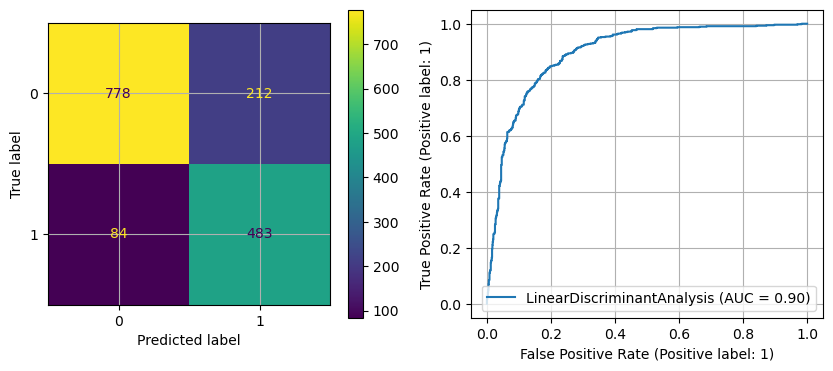

In [161]:
modelPerf(ldaModel, validX_scaled, validy)

Text(0.5, 1.0, '')

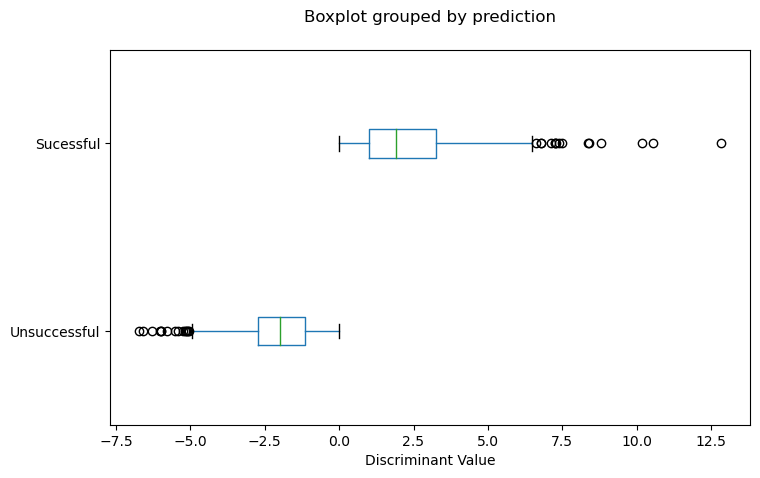

In [162]:
dfvalid = pd.DataFrame({'discriminant_value': ldaModel.decision_function(validX_scaled), 'prediction': ldaModel.predict(validX_scaled)})
fig, ax = plt.subplots(figsize = (8,5))
bplot = dfvalid.boxplot(by = 'prediction', ax = ax, vert=False, grid = False)
bplot.set_ylabel("")
bplot.set_yticks([1,2],['Unsuccessful', 'Sucessful'])
bplot.set_xlabel("Discriminant Value")
bplot.set_title("")

## 4. Partial Least Square

In [248]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

class PLSPreProc(PLSRegression):
    ''' Wrapper to allow PLSRegression to be used in the Pipeline Module '''
    def __init__(self, n_components=4, scale=False):
        super().__init__(n_components=n_components, scale=scale)

    def fit(self, X, y):
        return super().fit(X, y)

    def transform(self, X):
        return super().predict(X)

    def fit_transform(self, X, y):
        return super().fit(X,y).predict(X)

scaler = StandardScaler()
pls4 = PLSPreProc(4,False)
gnb = GaussianNB()

PLSNB = Pipeline([('scaler', StandardScaler()),('pls', pls4),('gnb',gnb)])

In [247]:
trainX = trainX0[fullSet+['yDay2']]
validX = validX0[fullSet+['yDay2']]

In [249]:
PLSNB.fit(trainX, trainy)

Pipeline(steps=[('scaler', StandardScaler()), ('pls', PLSPreProc()),
                ('gnb', GaussianNB())])

Report of Pipeline:
              precision    recall  f1-score   support

           0  0.8488166 0.8438235 0.8463127      3400
           1  0.8367661 0.8419425 0.8393463      3233

    accuracy                      0.8429067      6633
   macro avg  0.8427913 0.8428830 0.8428295      6633
weighted avg  0.8429430 0.8429067 0.8429172      6633

The area under the ROC curve is 0.9235688943068722


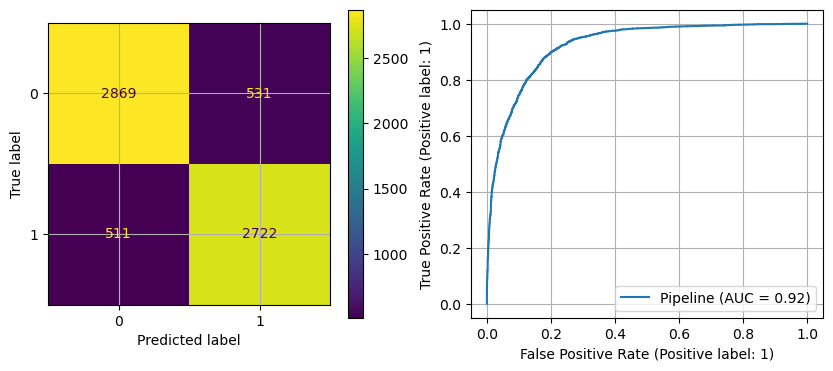

In [250]:
modelPerf(PLSNB,trainX,trainy)

Report of Pipeline:
              precision    recall  f1-score   support

           0  0.8726674 0.8030303 0.8364019       990
           1  0.6981424 0.7954145 0.7436109       567

    accuracy                      0.8002569      1557
   macro avg  0.7854049 0.7992224 0.7900064      1557
weighted avg  0.8091121 0.8002569 0.8026109      1557

The area under the ROC curve is 0.8583907861685639


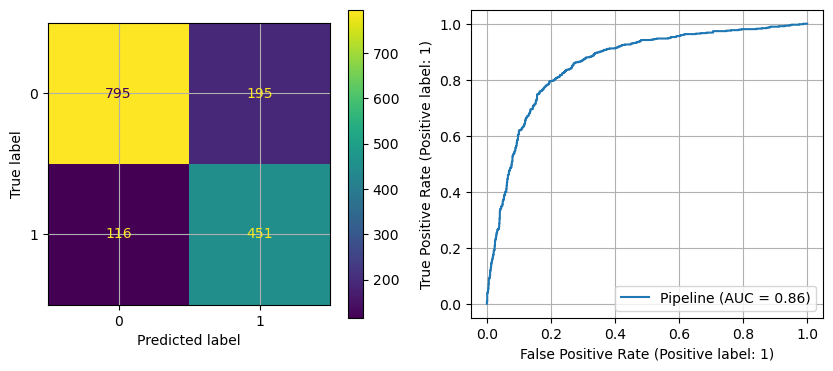

In [251]:
modelPerf(PLSNB, validX, validy)

Text(0.5, 1.0, '')

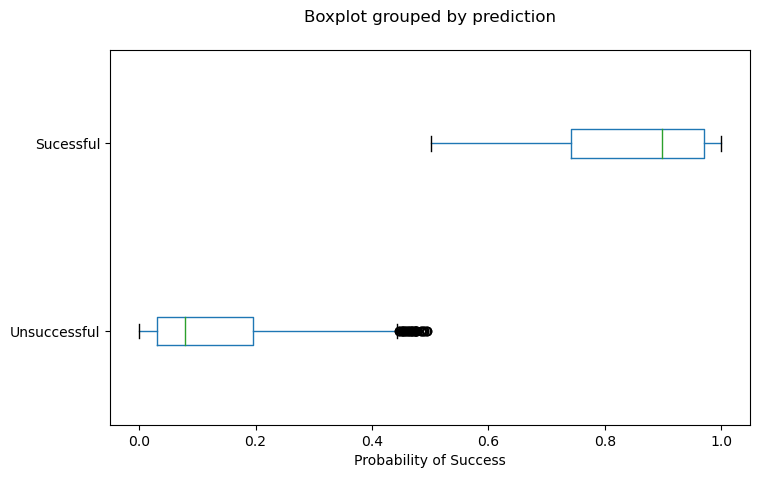

In [284]:
dfvalid = pd.DataFrame({'probability of success': PLSNB.predict_proba(validX)[:,1], 'prediction': PLSNB.predict(validX)})

fig, ax = plt.subplots(figsize = (8,5))
bplot = dfvalid.boxplot(by = 'prediction', ax = ax, vert=False, grid = False)
bplot.set_ylabel("")
bplot.set_yticks([1,2],['Unsuccessful', 'Sucessful'])
bplot.set_xlabel("Probability of Success")
bplot.set_title("")

## 5. Penalized Models